In [140]:
import os
import json
import yaml
import time
from redis import Redis
from rq import Queue, Retry
from rq.job import Job
import traceback
import sys
import networkx as nx
import warnings
import matplotlib.cbook
from joyflo import reactflow_to_networkx

In [141]:
import sys
dir_path = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(dir_path, os.pardir)))

In [142]:
from FUNCTIONS.GENERATORS import *
from FUNCTIONS.TRANSFORMERS import *
from FUNCTIONS.VISORS import *
from FUNCTIONS.COMPARATORS import *
from FUNCTIONS.LOOPS import *

In [143]:
stream = open('STATUS_CODES.yml', 'r',encoding="utf8")
STATUS_CODES = yaml.safe_load(stream)

from utils import PlotlyJSONEncoder

import os

REDIS_HOST = os.environ.get('REDIS_HOST', 'localhost')
REDIS_PORT = os.environ.get('REDIS_PORT', 6379)

In [144]:
r = Redis(host=REDIS_HOST, port=REDIS_PORT)
q = Queue('flojoy', connection=r) # FOR MAIN GRAPH

#### *FOR LOOP SUB-GRAPH*

In [145]:
loop_queue = Queue('loop',connection=r)

In [146]:
# Load React flow chart object from JSON file

f = open('./test-fc-loop.json')
fc = json.loads(f.read())
elems = fc['elements']

In [147]:
DG = nx.DiGraph()
DG.clear()

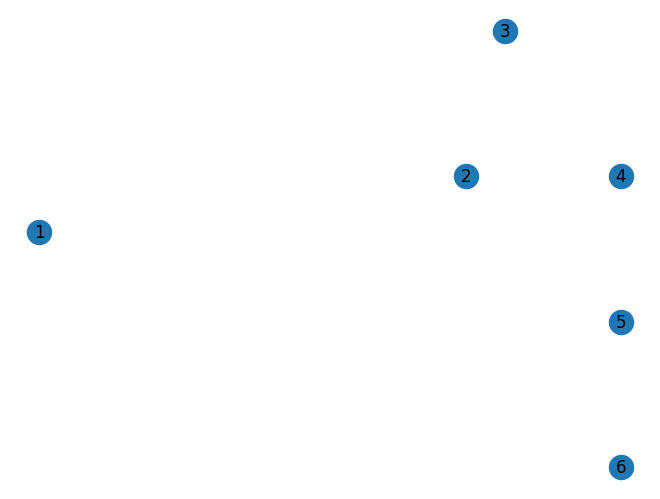

In [148]:
for i in range(len(elems)):
    el = elems[i]
    if 'source' not in el:
        data = el['data']
        ctrls = data['ctrls'] if 'ctrls' in data else {}
        DG.add_node(i+1, pos=(el['position']['x'], el['position']['y']), id=el['id'], ctrls=ctrls)
        elems[i]['index'] = i+1
        elems[i]['label'] = el['id'].split('-')[0]

pos = nx.get_node_attributes(DG,'pos')
nx.draw(DG, pos, with_labels=True)

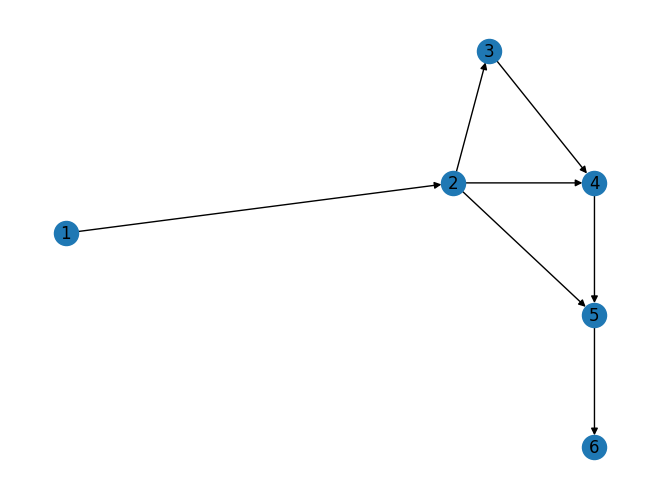

In [149]:
edge_label_dict = {}
def get_tuple(edge):
    e = [-1, -1]
    src_id = edge['source']
    tgt_id = edge['target']

    type = edge['type']
    if type == 'special':
        label = edge['label']
    else:
        label = 'default'
    if tgt_id not in edge_label_dict.keys():
        edge_label_dict[tgt_id] = []
    edge_label_dict[tgt_id].append({
        'source': src_id,
        'label':label
    })

    # iterate through all nodes looking for matching edge
    for el in elems:
        if 'id' in el:
            if el['id'] == src_id:
                e[0] = el['index']
            elif el['id'] == tgt_id:
                e[1] = el['index']
    return tuple(e)

for i in range(len(elems)):
    el = elems[i]
    if 'source' in el:
        # element is an edge
        e = get_tuple(el)
        DG.add_edge(*e)
nx.draw(DG, pos, with_labels=True)

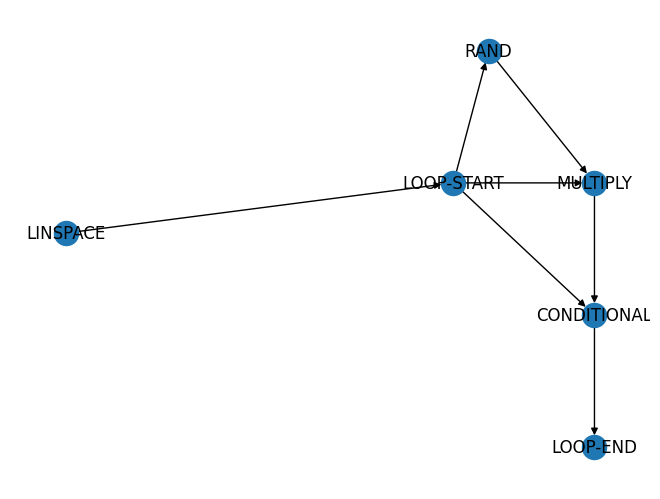

In [150]:
labels = {}
type = {}

for el in elems:
    # if element is not a node
    if 'source' not in el:
        labels[el['index']] = el['data']['label']
        type[el['index']] = el['type']
                
nx.set_node_attributes(DG, labels, 'cmd')                             
nx.set_node_attributes(DG, type,'type')
nx.draw(DG, pos, with_labels=True, labels = labels)

In [151]:
def get_node_data_by_id():
    nodes_by_id = dict()
    for n, nd in DG.nodes().items():
        nodes_by_id[n] = nd
    return nodes_by_id

def report_failure(job, connection, type, value, traceback):
    print(job, connection, type, value, traceback)

def jid(n):
    return 'JOB_ID_{0}'.format(n)

topological_sorting = nx.topological_sort(DG)
nodes_by_id = get_node_data_by_id()
topological_sorting_list = list(topological_sorting)

In [152]:
len(topological_sorting_list)

6

In [153]:
# topological_sorting_list[9]

In [154]:
cycle_nodes = nx.find_cycle(DG,orientation='ignore')

In [155]:
for value in cycle_nodes:
    print(value[0])

2
3
4
2


In [156]:
list_of_loops = {}
loop_count = 1
for value in cycle_nodes:
    node_serial = value[0]
    node_id = nodes_by_id[node_serial]['id']

    print(node_id)

    if 'LOOP-START' in node_id:
        if loop_count not in list_of_loops.keys():
            list_of_loops[loop_count] = []
        list_of_loops[loop_count].append(node_serial)
        expected_next_node = node_serial + 1
    elif node_serial == expected_next_node:
        list_of_loops[loop_count].append(node_serial)
        expected_next_node = node_serial + 1
    if 'LOOP-END' in node_id:
        list_of_loops[loop_count].append(node_serial)
        loop_count = loop_count + 1
    
list_of_loops

LOOP-START-userGeneratedNode_1646417604301
RAND-userGeneratedNode_1646417371398
MULTIPLY-userGeneratedNode_1646417352715
LOOP-START-userGeneratedNode_1646417604301


{1: [2, 3, 4, 2]}

In [157]:
# sub_graph = DG.subgraph([1,2,3])
# print(list(nx.topological_sort(sub_graph)))

In [158]:
for n, nd in DG.nodes().items():
    print('node', n, 'node data', nd)

for node in nx.topological_sort(DG):
    print(node)

node 1 node data {'pos': (0, 262), 'id': 'LINSPACE-userGeneratedNode_1646432683694', 'ctrls': {'LINSPACE_LINSPACE_START': {'functionName': 'LINSPACE', 'param': 'start', 'value': 1}, 'LINSPACE_LINSPACE_END': {'functionName': 'LINSPACE', 'param': 'end', 'value': 14}, 'LINSPACE_LINSPACE_STEP': {'functionName': 'LINSPACE', 'param': 'step', 'value': 3}}, 'cmd': 'LINSPACE', 'type': 'default'}
node 2 node data {'pos': (550, 300), 'id': 'LOOP-START-userGeneratedNode_1646417604301', 'ctrls': {'flow_control_value': {'initial_value': 0, 'numder_of_iterations': 1}}, 'cmd': 'LOOP-START', 'type': 'special'}
node 3 node data {'pos': (600, 400), 'id': 'RAND-userGeneratedNode_1646417371398', 'ctrls': {}, 'cmd': 'RAND', 'type': 'default'}
node 4 node data {'pos': (750, 300), 'id': 'MULTIPLY-userGeneratedNode_1646417352715', 'ctrls': {}, 'cmd': 'MULTIPLY', 'type': 'default'}
node 5 node data {'pos': (750, 200), 'id': 'CONDITIONAL-userGeneratedNode_1646435677929', 'ctrls': {'CONDITIONAL_OPERATOR': {'opera

In [159]:
'''
    @func wait_for_special_type_job_to_finish
    description: Waits for special type node like conditional to finish, so that the code flow is in the right direction.
'''

def wait_for_special_type_job_to_finish(n):
   
    job_id = jid(n)
    job = None
    try:
        job = Job.fetch(job_id, connection=r)
        nd = nodes_by_id[n]
    except Exception:
        print(traceback.format_exc())

    job_status,is_node_failed,attempt_count = None,False,0

    while True:
        time.sleep(0.5)
        job_status= job.get_status(refresh=True)
        attempt_count += 1
        print('Job status:', nd['cmd'], job_status, 'origin:', job.origin, 'attempt:', attempt_count)
        
        if job_status == 'finished':
            is_node_failed = False
            break

        if is_node_failed:
            print('canceling', nd['cmd'], 'due to failure in another node')
            job.delete()
            job_status = "cancelled"
            break

        if job_status == 'failed':
            is_node_failed = True
            break

        if job_status == 'deferred':
            registry = q.deferred_job_registry
            registry.requeue(job_id)
    print("IS ANY NODE FAILED ",is_node_failed)
    return True if not is_node_failed else False

In [160]:
def find_edge_label(source_id,destination_id):
    for key, value in edge_label_dict.items():
        if key == destination_id:
            for ind_value in value:
                if ind_value['source'] == source_id:
                    return ind_value['label']
    return None

In [161]:
def is_eligible_to_enqueue(node_serial,enqued_jobs_list):
    
    '''
        TODO Check Predecessor:
             - IF any Predecessor is special type, then check edge label, if both true, then pass the 
    '''

    previous_job_ids = []
    is_eligible = True
    for p in DG.predecessors(node_serial):
        type = nodes_by_id[p]['type']
        cmd = nodes_by_id[p]['cmd']
        job_id = jid(p)
        if type == 'special':

            '''
                TODO: check if the predecessor result is ready.
            '''

            status = wait_for_special_type_job_to_finish(p)
            if not status:
                return False,[]

            job = Job.fetch(job_id, connection=r)
            result = job.result

            if cmd == 'CONDITIONAL':
                print(result)
                flow_direction = result['direction']
                print('conditional flow direction ',flow_direction)
                source_id = nodes_by_id[p]['id']
                destination_id = nodes_by_id[node_serial]['id']
                label = find_edge_label(source_id,destination_id)

                if (flow_direction is not None) and (label != flow_direction):
                    return False,[]
            previous_job_ids.append(job_id)
        else:

            if job_id not in enqued_jobs_list:
                return False,[]
            else:
                previous_job_ids.append(job_id)
                
    return is_eligible,previous_job_ids

##### *LOOP FEATURE ALGORITHM* (When users can't define any cycle edge)

    - LOOP-START node found -> wait for previous nodes to finish the jobs (scheduled stoppping)
    - Finding which nodes belong to Loop
    - CONDITIONAL node output False -> Keep looping 
        - Passing the previous iteration result to the next iteration, through LOOP-START node
        - Keep checking if the loop iteration completed
    - CONDITIONAL node output True -> Break the loop

In [162]:
def enqueue_nodes(node_list):
    pass

In [163]:
def find_looped_nodes():
    pass

In [164]:
def check_if_part_of_loop(node_serial):
    cmd = nodes_by_id[node_serial]['cmd']
    if cmd == 'LOOP-START':
        return True
    
    for p in DG.predecessors(node_serial):
        predecessor_cmd = nodes_by_id[p]['cmd']
        if predecessor_cmd == 'LOOP-START':
            return True

In [165]:
def handle_loop(looped_jobs_dict):
    '''
        1. Collect Previous iteration result
        2. if node LOOP-START , Pass that nodes Job_id ( appending previous nodes ids), in Loop node's predecessor (using kwargs)
        3. 
    '''
    for key,value in looped_jobs_dict.items():

        node_serial = value['node_serial']
        cmd = key
        ctrls = value['ctrls']
        job_id = jid(node_serial)
        previous_job_ids = [jid(p) for p in DG.predecessors(node_serial)]

        if cmd == "LOOP-START" or cmd == "LOOP-END":
            func = getattr(globals()["LOOP"], "LOOP")
        else:
            func = getattr(globals()[cmd], cmd)

        if cmd == 'LOOP-START':
            previous_iteration_count = ctrls['flow_control_value']['initial_value']
            ctrls['flow_control_value']['initial_value'] = previous_iteration_count + 1

            print(previous_iteration_count)

            previous_job_result_id = jid(looped_jobs_dict['CONDITIONAL']['node_serial'])
            previous_job_ids.append(previous_job_result_id)
            
        q.enqueue(func,
            retry=Retry(max=100),
            job_timeout='3m',
            on_failure=report_failure,
            job_id=job_id,
            kwargs={'ctrls': ctrls,'previous_job_ids':previous_job_ids},
            depends_on=previous_job_ids,
            result_ttl=500)

In [166]:
enqued_jobs_list = []
looped_jobs_list = {}
loop_start_node = None
loop_end_node = None
index = 0

while index < len(topological_sorting_list):
    print(index)
    n = topological_sorting_list[index]
    cmd,ctrls,type = get_node_data_by_id()[n]['cmd'],get_node_data_by_id()[n]['ctrls'],get_node_data_by_id()[n]['type']

    '''
        TODO: MUST CHECK PREDECESSORS IF ANYONE OF THEM IS SPECIAL TYPE NODES OR NOT
              IF IT'S A SPECIAL TYPE NODE, THEN WAIT FOR THE NODE RESULT.
              AND COMPARE THE NODE OUTPUT & LABEL.
    '''

    job_id = jid(n)
    if cmd == "LOOP-START" or cmd == "LOOP-END":
        func = getattr(globals()["LOOP"], "LOOP")
    else:
        func = getattr(globals()[cmd], cmd)
    
    s = ' '.join([STATUS_CODES['JOB_IN_RQ'], cmd.upper()])
    r.set('SYSTEM_STATUS', s)

    if len(list(DG.predecessors(n))) == 0:
        # print('{0} ({1}) has no predecessors'.format(cmd, n))
        q.enqueue(func,
            retry=Retry(max=100), # TODO: have to understand why the SINE node is failing for few times then succeeds
            job_timeout='3m',
            on_failure=report_failure,
            job_id = job_id,
            kwargs={'ctrls': ctrls},
            result_ttl=500)
        print('ENQUEUING...', cmd, job_id, ctrls)
        enqued_jobs_list.append(job_id)
        index = index + 1

    else:
        is_eligible,previous_job_ids = is_eligible_to_enqueue(node_serial=n,enqued_jobs_list=enqued_jobs_list)
        
        if is_eligible:
            status = check_if_part_of_loop(n)
            if status:
                looped_jobs_list[cmd] = {
                    'node_serial' : n,
                    'ctrls' : ctrls
                }
            
            q.enqueue(func,
                retry=Retry(max=100),
                job_timeout='3m',
                on_failure=report_failure,
                job_id=job_id,
                kwargs={'ctrls': ctrls,'previous_job_ids':previous_job_ids},
                depends_on=previous_job_ids,
                result_ttl=500)
            print('ENQUEUING...', cmd, job_id, ctrls, previous_job_ids)
            enqued_jobs_list.append(job_id)
            index = index + 1
        else:
            if cmd == 'LOOP-END':
                print(looped_jobs_list)
                handle_loop(looped_jobs_list)
        

0
ENQUEUING... LINSPACE JOB_ID_1 {'LINSPACE_LINSPACE_START': {'functionName': 'LINSPACE', 'param': 'start', 'value': 1}, 'LINSPACE_LINSPACE_END': {'functionName': 'LINSPACE', 'param': 'end', 'value': 14}, 'LINSPACE_LINSPACE_STEP': {'functionName': 'LINSPACE', 'param': 'step', 'value': 3}}
1
ENQUEUING... LOOP-START JOB_ID_2 {'flow_control_value': {'initial_value': 0, 'numder_of_iterations': 1}} ['JOB_ID_1']
2
Job status: LOOP-START started origin: flojoy attempt: 1
Job status: LOOP-START finished origin: flojoy attempt: 2
IS ANY NODE FAILED  False
ENQUEUING... RAND JOB_ID_3 {} ['JOB_ID_2']
3
Job status: LOOP-START finished origin: flojoy attempt: 1
IS ANY NODE FAILED  False
ENQUEUING... MULTIPLY JOB_ID_4 {} ['JOB_ID_2', 'JOB_ID_3']
4
Job status: LOOP-START finished origin: flojoy attempt: 1
IS ANY NODE FAILED  False
ENQUEUING... CONDITIONAL JOB_ID_5 {'CONDITIONAL_OPERATOR': {'operator': 'IS_GREATER_THAN', 'functionName': '', 'param': '', 'value': None}} ['JOB_ID_2', 'JOB_ID_4']
5
Job st

In [139]:
job = Job.fetch('JOB_ID_5', connection=Redis(host=REDIS_HOST, port=REDIS_PORT))
job.kwargs['ctrls']['CONDITIONAL_OPERATOR']['functionName']

''